<a href="https://colab.research.google.com/github/AminaTkh/AlanTuringInstitute_Bias_in_AI_Beyond_Binary_Classification/blob/main/ClusteringMitigatingBiasExercises.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mitigating Bias in a Clustering Model

In this notebook, we will be mitigating bias in a clustering model by creating a pipeline to implement bias mitigation techniques from the holisticai library. All questions and tasks are bolded and in red.

### 0 - Importing modules and loading the data

We begin by loading the dataset. For this milestone, we will be using the 'Adult Data Set' from the UC Irvine Machine Learning Repository and loading it directly from the holisticai library. The dataset contains information extracted from the US 1994 Census database and is used to predict whether a person's annual income exceeds $50,000. In this tutorial we will perform unsupervised learning to cluster the data, then measure whether the clusters contain gender or race information (clustering bias).

In [1]:
# make sure you have holisticai library installed
!pip install holisticai

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 241.9/241.9 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.3/9.3 MB 73.6 MB/s eta 0:00:00


In [2]:
# Base Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')


# import dataset
from holisticai.datasets import load_adult

# import plotting functions
from holisticai.bias.plots import group_pie_plot
from holisticai.bias.plots import histogram_plot
from holisticai.bias.plots import frequency_matrix_plot

# import some bias metrics
from holisticai.bias.metrics import cluster_balance
from holisticai.bias.metrics import min_cluster_ratio
from holisticai.bias.metrics import clustering_bias_metrics

# import bias mitigation techniques
from holisticai.bias.mitigation import VariationalFairClustering
from holisticai.bias.mitigation import FairletClusteringPreprocessing
from holisticai.bias.mitigation.commons.fairlet_clustering.clustering._kmedoids import KMedoids

# import pipeline function
from holisticai.pipeline import Pipeline

In [3]:
from holisticai.datasets import load_adult
df = load_adult()['frame']
df

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,class
0,25.0,Private,226802.0,11th,7.0,Never-married,Machine-op-inspct,Own-child,Black,Male,0.0,0.0,40.0,United-States,<=50K
1,38.0,Private,89814.0,HS-grad,9.0,Married-civ-spouse,Farming-fishing,Husband,White,Male,0.0,0.0,50.0,United-States,<=50K
2,28.0,Local-gov,336951.0,Assoc-acdm,12.0,Married-civ-spouse,Protective-serv,Husband,White,Male,0.0,0.0,40.0,United-States,>50K
3,44.0,Private,160323.0,Some-college,10.0,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688.0,0.0,40.0,United-States,>50K
4,18.0,NaN,103497.0,Some-college,10.0,Never-married,NaN,Own-child,White,Female,0.0,0.0,30.0,United-States,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48837,27.0,Private,257302.0,Assoc-acdm,12.0,Married-civ-spouse,Tech-support,Wife,White,Female,0.0,0.0,38.0,United-States,<=50K
48838,40.0,Private,154374.0,HS-grad,9.0,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0.0,0.0,40.0,United-States,>50K
48839,58.0,Private,151910.0,HS-grad,9.0,Widowed,Adm-clerical,Unmarried,White,Female,0.0,0.0,40.0,United-States,<=50K
48840,22.0,Private,201490.0,HS-grad,9.0,Never-married,Adm-clerical,Own-child,White,Male,0.0,0.0,20.0,United-States,<=50K


In [4]:
df

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,class
0,25.0,Private,226802.0,11th,7.0,Never-married,Machine-op-inspct,Own-child,Black,Male,0.0,0.0,40.0,United-States,<=50K
1,38.0,Private,89814.0,HS-grad,9.0,Married-civ-spouse,Farming-fishing,Husband,White,Male,0.0,0.0,50.0,United-States,<=50K
2,28.0,Local-gov,336951.0,Assoc-acdm,12.0,Married-civ-spouse,Protective-serv,Husband,White,Male,0.0,0.0,40.0,United-States,>50K
3,44.0,Private,160323.0,Some-college,10.0,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688.0,0.0,40.0,United-States,>50K
4,18.0,NaN,103497.0,Some-college,10.0,Never-married,NaN,Own-child,White,Female,0.0,0.0,30.0,United-States,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48837,27.0,Private,257302.0,Assoc-acdm,12.0,Married-civ-spouse,Tech-support,Wife,White,Female,0.0,0.0,38.0,United-States,<=50K
48838,40.0,Private,154374.0,HS-grad,9.0,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0.0,0.0,40.0,United-States,>50K
48839,58.0,Private,151910.0,HS-grad,9.0,Widowed,Adm-clerical,Unmarried,White,Female,0.0,0.0,40.0,United-States,<=50K
48840,22.0,Private,201490.0,HS-grad,9.0,Never-married,Adm-clerical,Own-child,White,Male,0.0,0.0,20.0,United-States,<=50K


### 1- Pre-processing the data

Similar to the bias measurement notebook, we are going to prepare the data for the training of a clustering model. We will use sklearn's k-means clustering as our model of choice, and we use its train_test_split function to split our dataset. Note, we do not want to include protected attributes in the training so we will remove 'sex', and 'race' from the features during training and inference.

In [5]:
dataset = load_adult()

# Dataframe
df = pd.concat([dataset["data"], dataset["target"]], axis=1)
protected_variables = ["sex", "race"]
output_variable = ["class"]

# Simple preprocessing
y = df[output_variable].replace({">50K": 1, "<=50K": 0})
X = pd.get_dummies(df.drop(protected_variables + output_variable, axis=1))
data = [X, y]

# Train test split
dataset = train_test_split(*data, test_size=0.2, shuffle=True,random_state=42)
train_data = dataset[::2]
test_data = dataset[1::2]

### 2 - Training the model and measuring bias


In this section, we will train a k-means clustering model from sklearn and then measure bias using the metrics from the the holisticai library. We will use the results from the measuring bias notebook and use 4-cluster model.

In [6]:
# we choose to use 4 clusters
X_train, _= train_data

model = KMeans(n_clusters = 4)
model.fit(X_train)

# test data
X, _ = test_data

# predict
y_pred = model.predict(X)

We will begin our mitigation process by looking at the 'sex' attribtute. Let's compare how the model performs with respect to 'Male' and 'Female' entries. Using the frequency_matrix_plot and normalizing with respect to group we can see that the distribution amongst the clusters are fairly balanced with respect to sex.

<Axes: xlabel='Class', ylabel='Group'>

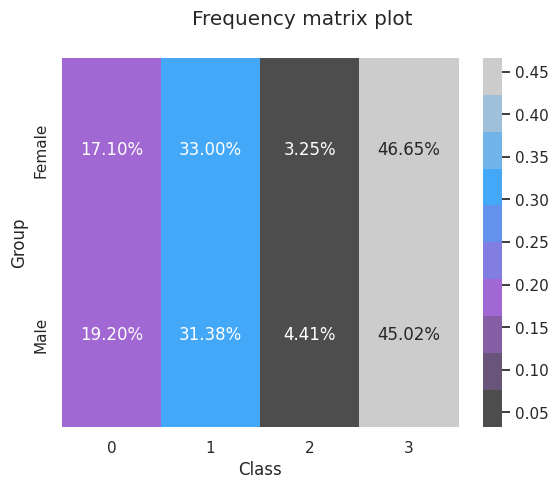

In [7]:
p_attr_sex = df.iloc[X.index]['sex']
p_attr_race = df.iloc[X.index]['race']
y_pred = model.predict(X)

# probability for each gender and class
frequency_matrix_plot(p_attr_sex, y_pred, normalize='group')

We can do the same for the 'race' attribute. As we can see below, when we normalize the frequency_matrix_plot by group, there is a clear un balance in the clusters amongst the different races.

<Axes: xlabel='Class', ylabel='Group'>

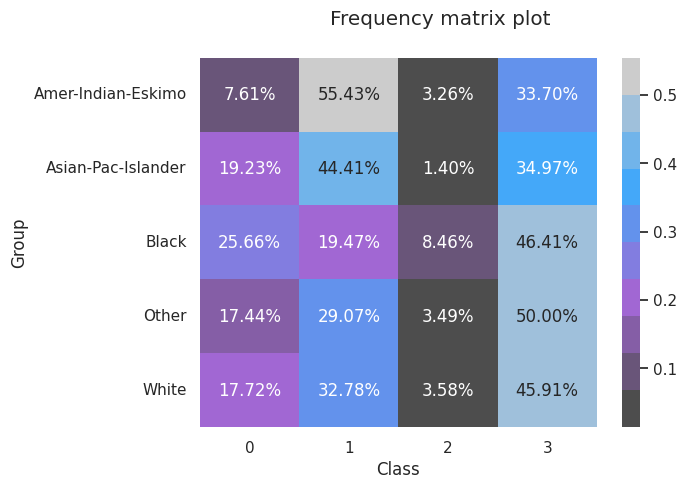

In [8]:
frequency_matrix_plot(p_attr_race, y_pred, normalize='group')

Let's calculate a summary of bias metrics using the 'race' protected attribute. Using the clustering_bias_metrics function, we can calculate all the 'equal outcome' bias metrics for clustering.

In [9]:
# set up data arrays
group_a = p_attr_race=='Amer-Indian-Eskimo'
group_b = p_attr_race=='White'
y_pred = y_pred
centroids = model.cluster_centers_
data = X.to_numpy()
clustering_bias_metrics(group_a, group_b, y_pred, data = data, centroids = centroids, metric_type = 'equal_outcome')

,Value,Reference
Metric,,
Cluster Balance,0.411341,1
Minimum Cluster Ratio,0.004765,1
Cluster Distribution Total Variation,0.226524,0
Cluster Distribution KL Div,0.119565,0
Social Fairness Ratio,1.225273,1
Silhouette Difference,0.000701,0


From the summary of bias metrics presented above, we can see that there is reason to believe there is bias in the model as the majority of the metrics are relatively far from their references. To combat this, we will implement two bias mitigation techniques in the next section.

### 3 - Implementing mitigation techniques

For this paricular notebook, we will be implenting mitigaiton techniques from two different levels: pre-processing and in-processing.

#### 3.1 - Pre-Processing Methods for Bias Mitigation

We begin with the Pre-processing techniques. Pre-processing operates on the data level and aims to either combat representation bias or historical bias. To deal with unbalanced data sets experiencing representational bias, pre-processing techniques strategically sample to oversample underrepresented groups. To handle historical bias, data sets that reinforce stereotypes of certain groups, pre-processing techniques aim to remove any proxies to or notions of group membership from the data. We will be implementing the Fair Clustering Through Fairlet (Chierichetti et al. 2017) which aims to have equal representation of each protected attribute in each cluster. We implement the version of the algorithm from Backurs, Arturs, et al. "Scalable Fair Clustering." 2019.

In [10]:
# initialize groups for measuring bias on training set
p_attr_sex_train = df.iloc[X_train.index]['sex']
p_attr_race_train = df.iloc[X_train.index]['race']

group_a_train = p_attr_sex_train=='Female'
group_b_train = p_attr_sex_train=='Male'

# initialize pre-processing method
decomposition = FairletClusteringPreprocessing(decomposition='Scalable', p=10, q=21, seed=42)

# initialize pipeline
pipeline = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('bm_preprocessing', decomposition),
    ('cluster', KMeans(n_clusters=4))])

# fit mitigation technique and train model on training data
pipeline.fit(X_train, bm__group_a = group_a_train, bm__group_b = group_b_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('bm_preprocessing',
                 FairletClusteringPreprocessing(decomposition=<holisticai.bias.mitigation.commons.fairlet_clustering.decompositions._scalable.ScalableFairletDecomposition object at 0x7fadd3904910>,
                                                p=10, q=21, seed=42)),
                ('cluster',
                 <holisticai.pipeline.handlers._estimator.WEstimator object at 0x7fadd39045b0>)])

In [11]:
# initialize groups for testing
group_a = p_attr_sex=='Female'
group_b = p_attr_sex=='Male'

# extract cluster centroids from model
fairlet_centroids = pipeline['cluster'].cluster_centers_

# make a prediction on test set
fairlet_y_pred = pipeline.predict(X)

# calculate metrics from test set
clustering_bias_metrics(group_a,
                                  group_b,
                                  fairlet_y_pred,
                                  data = X,
                                  centroids = fairlet_centroids,
                                  metric_type = 'both')

,Value,Reference
Metric,,
Cluster Balance,0.780686,1
Minimum Cluster Ratio,0.352013,1
Cluster Distribution Total Variation,0.136622,0
Cluster Distribution KL Div,0.040800,0
Social Fairness Ratio,0.960548,1
Silhouette Difference,-0.001899,0


There is a noticable improvement with respect to each metric and the majority of them are well within acceptable values. Notice the order of the steps in the pipeline. First, the standard scalar is applied, then the pre-processing method and finally the model.

#### 3.2 - In-Processing Methods for Bias Mitigation

In-processing algorithms operate at the algorithmic level and are applied *during* training. Many in-processing algorithms add a classification constraint to the loss function to enforce fairness, while others aim to remove any indicators of sensitive attributes. We will implement the Variational Fair Clustering method (Ziko, Imtiaz Masud, et al. 2021), which aims to balance the trade off between fairness and clustering objectives by intergrating a KL fairness term with a large class of clustering objectives. In other words, this method aims to find clusters with specified proportions of different demographic groups pertaining to a sensitive attribute. We will use the holisticai pipeline to house both the standard scaler method and the inprocessing technique itself.

<font color='red'> **Task 1**

**Implement the ML Debiaser in-processing technique (VariationalFairClustering) using the pipeline method with 4 clusters. Generate a summary of bias metrics and use the summary to comment on the performance of the algorithm with respect to the 'race' attribute using 'Amer-Indian-Eskimo' and 'White' as group_a and group_b respectively. (Hint: the order of pipeline steps is different than in the pre-processing example. In addition to this, the processing algorithm already contains the clustering function)**
<font >

,Value,Reference
Metric,,
Cluster Balance,0.633309,1
Minimum Cluster Ratio,0.006572,1
Cluster Distribution Total Variation,0.224405,0
Cluster Distribution KL Div,0.102907,0
Social Fairness Ratio,0.760016,1
Silhouette Difference,-0.003999,0


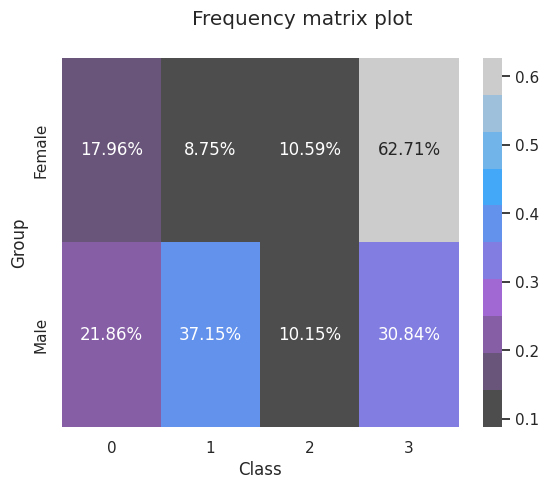

In [14]:
# initialize groups for measuring bias on training and test set
group_a_train = p_attr_race_train=='Amer-Indian-Eskimo'
group_b_train = p_attr_race_train=='White'

group_a = p_attr_race=='Amer-Indian-Eskimo'
group_b = p_attr_race=='White'

# initialize in-processing technique

var = VariationalFairClustering(n_clusters = 4)
# initialize the pipeline

pipeline = Pipeline(steps = [
   ('scaler', StandardScaler()),
   ('bm_inprocessing', var)
])

# fit on training data
pipeline.fit(X_train, bm__group_a = group_a_train, bm__group_b = group_b_train)

# make predictions on test data
vfc_pred = pipeline.predict(X, bm__group_a=group_a, bm__group_b=group_b)

# get cluster centroids
vfc_centroids = pipeline['bm_inprocessing'].cluster_centers_

# probability for each sex and group
frequency_matrix_plot(p_attr_sex, vfc_pred, normalize='group')

# get bias metrics
clustering_bias_metrics(group_a, group_b, vfc_pred, data = data, centroids = vfc_centroids, metric_type = 'both')